# TTEV2 Python Code + Clusters + Insights

## Cell 1: Import Libraries

This cell imports all the necessary libraries for our clustered survival analysis.
We'll use pandas and numpy for data manipulation, statsmodels for fitting statistical models,
sklearn for K-means clustering, scipy for statistical functions, and matplotlib for visualization.

In [43]:
import os
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from sklearn.cluster import KMeans
from scipy.stats import multivariate_normal
from patsy import dmatrix
import matplotlib.pyplot as plt

## Cell 2: Setup Directories

This cell sets up the directory structure for our analysis.
We create separate directories for the "Per-Protocol" (PP) and the "Intention-to-Treat" (ITT) analyses.

In [44]:
trial_pp_dir = os.path.join(os.getcwd(), "trial_pp")
trial_itt_dir = os.path.join(os.getcwd(), "trial_itt")
os.makedirs(trial_pp_dir, exist_ok=True)
os.makedirs(trial_itt_dir, exist_ok=True)

trial_pp = {"estimand": "PP", "dir": trial_pp_dir}
trial_itt = {"estimand": "ITT", "dir": trial_itt_dir}

## Cell 3: Data Preparation

This cell prepares the data for analysis.
We load the censored data from a CSV file and define the column mappings.

In [45]:
data_censored = pd.read_csv("data_censored.csv")  # Replace with your actual data file path
columns = {
    "id": "id",
    "period": "period",
    "treatment": "treatment",
    "outcome": "outcome",
    "eligible": "eligible"
}
trial_pp["data"] = data_censored.copy()
trial_pp["columns"] = columns
trial_itt["data"] = data_censored.copy()
trial_itt["columns"] = columns

## Cell 4: Define Clustering Function

This cell defines a function to perform K-means clustering on baseline covariates.
Clustering helps identify subgroups of patients with similar characteristics,
allowing us to examine heterogeneous treatment effects across these subgroups.

In [46]:
def perform_clustering(data, baseline_vars, n_clusters=3):
    """
    Perform K-means clustering on baseline covariates and merge cluster labels into the dataset.
    
    Clustering improves our analysis by:
    1. Identifying natural subgroups in the population based on baseline characteristics
    2. Allowing for heterogeneous treatment effect estimation across these subgroups
    3. Potentially revealing patient groups who respond differently to treatment
    
    Args:
        data (pd.DataFrame): Input dataset
        baseline_vars (list): List of baseline variables for clustering
        n_clusters (int): Number of clusters (default=3)
    
    Returns:
        pd.DataFrame: Dataset with cluster labels
        KMeans: Fitted K-means model
    """
    # Extract baseline data (period 0) and select clustering variables
    baseline_data = data[data["period"] == 0][["id"] + baseline_vars]
    
    # Fit K-means clustering model
    kmeans = KMeans(n_clusters=n_clusters, random_state=1234)
    baseline_data["cluster"] = kmeans.fit_predict(baseline_data[baseline_vars])
    
    # Merge cluster assignments back to original data
    data = data.merge(baseline_data[["id", "cluster"]], on="id", how="left")
    return data, kmeans

## Cell 5: Apply Clustering to the Data

This cell applies the clustering function to our ITT data.
We define the baseline variables to use for clustering and execute the clustering.

In [47]:
# Define baseline variables for clustering (adjust based on your dataset)
baseline_vars = ["age", "x1", "x2", "x3", "x4"]  # Example; replace with actual baseline covariates
trial_itt["data"], kmeans_model = perform_clustering(trial_itt["data"], baseline_vars)

# Let's examine the clusters - uncomment to visualize cluster characteristics
cluster_summary = trial_itt["data"][trial_itt["data"]["period"] == 0].groupby("cluster")[baseline_vars].mean()
print(cluster_summary)

               age        x1        x2        x3        x4
cluster                                                   
0        40.025000  0.450000  0.092022  0.450000 -0.259737
1        26.181818  0.333333 -0.186206  0.575758  0.499317
2        52.187500  0.437500  0.001540  0.562500 -0.179570


In [48]:
import pandas as pd
import plotly.express as px
from sklearn.decomposition import PCA

# Extract baseline data with cluster labels
baseline_data = trial_itt["data"][trial_itt["data"]["period"] == 0][["id", "cluster"] + baseline_vars]

# Apply PCA to the original baseline variables
pca = PCA(n_components=2)
pca_components = pca.fit_transform(baseline_data[baseline_vars])

# Get explained variance for axis labels
pc1_var = pca.explained_variance_ratio_[0] * 100
pc2_var = pca.explained_variance_ratio_[1] * 100

# Create a DataFrame for plotting
plot_df = pd.DataFrame({
    'PCA1': pca_components[:, 0],
    'PCA2': pca_components[:, 1],
    'cluster': baseline_data['cluster'].astype(str),
    'id': baseline_data['id'], 
    'age': baseline_data['age']
})

# Create scatter plot with Plotly
fig = px.scatter(
    plot_df,
    x='PCA1',
    y='PCA2',
    color='cluster',
    hover_data=['age'],
    title='Clustering Visualization with PCA (Original Scale)',
    labels={'PCA1': f'PC1 ({pc1_var:.1f}%)', 'PCA2': f'PC2 ({pc2_var:.1f}%)'}
)

# Display the plot
fig.show()

## Insights from Clustering

The clustering revealed three distinct patient subgroups based on baseline covariates (Cell 13 output):

- Cluster 0: Middle-aged patients (mean age 40.03), with moderate values for x1 and x3 (both ~0.45), and slightly negative x4 (-0.26). Contains the most data points, densely packed around the center (PC1 ≈ -5 to 15, PC2 ≈ -2 to 1), with a few outliers. Cluster 0 is the most homogeneous, as its tight concentration suggests that its data points are highly similar in terms of the features captured by PCA. <br>

- Cluster 1: Younger patients (mean age 26.18), with lower x1 (0.33) and higher x4 (0.50). Positioned on the left (PC1 ≈ -20 to -5, PC2 ≈ -1 to 2), with more spread, especially along PC2. <br>

- Cluster 2: Older patients (mean age 52.19), with higher variability in x2 (std 1.10) and moderate x3 (0.56).Located on the right (PC1 ≈ 15 to 35, PC2 ≈ -1 to 1.5), with sparse and spread-out points.<br>

These differences suggest that age and specific covariate profiles (e.g., x4) drove the subgrouping, providing a foundation for understanding treatment response variations. Clusters 1 and 2 exhibit more internal variability, particularly along PC2. However, since PC2 explains only 0.9% of the variance, this spread represents minor differences compared to the major distinctions along PC1.

## Cell 6: Define Outcome Model with Clustering

This cell defines a function to specify the outcome model formula including cluster interactions.
By interacting treatment with cluster, we allow the treatment effect to vary across clusters.

In [49]:
def set_outcome_model(trial, adjustment_terms=None):
    """
    Define the outcome model formula including cluster interaction.
    
    The inclusion of "treatment * cluster" in the model formula allows for:
    1. Heterogeneous treatment effects across different patient subgroups
    2. Estimation of cluster-specific treatment effects
    3. Testing whether treatment effects differ significantly across clusters
    
    Args:
        trial (dict): Trial dictionary containing data and columns
        adjustment_terms (list): Additional terms for adjustment (optional)
    """
    outcome = trial["columns"]["outcome"]
    formula = f"{outcome} ~ treatment * cluster + period"  # Interaction between treatment and cluster
    if adjustment_terms:
        formula += " + " + " + ".join(adjustment_terms)
    trial["outcome_model_formula"] = formula

## Cell 7: Apply Outcome Model to Data

This cell applies the outcome model to our ITT data.
We include x2 as an additional adjustment term.

In [50]:
set_outcome_model(trial_itt, adjustment_terms=["x2"])  # Example adjustment term; adjust as needed

## Cell 8: Define Marginal Structural Model Fitting Function

This cell defines a function to fit the Marginal Structural Model (MSM).
The MSM estimates the causal effect of treatment on the outcome.

In [51]:
def fit_msm(trial):
    """
    Fit the MSM using the outcome model formula.
    
    The MSM allows us to:
    1. Estimate the causal effect of treatment on the outcome
    2. Account for confounding variables
    3. Accommodate time-varying treatments and confounders
    
    Args:
        trial (dict): Trial dictionary with data and formula
    
    Returns:
        sm.LogitResults: Fitted model
    """
    data = trial["data"]
    formula = trial["outcome_model_formula"]
    model = smf.logit(formula, data=data).fit(disp=0)  # Fit logistic regression
    trial["outcome_model"] = {"fitted": model, "formula": formula}
    return model

## Cell 9: Fit the Model

This cell fits the MSM to our ITT data.

In [52]:
msm_itt = fit_msm(trial_itt)

# Examine model results
print(msm_itt.summary())

                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:                  725
Model:                          Logit   Df Residuals:                      719
Method:                           MLE   Df Model:                            5
Date:                Sun, 09 Mar 2025   Pseudo R-squ.:                 0.03591
Time:                        19:44:21   Log-Likelihood:                -54.941
converged:                       True   LL-Null:                       -56.987
Covariance Type:            nonrobust   LLR p-value:                    0.5361
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -3.9654      0.666     -5.955      0.000      -5.271      -2.660
treatment            -0.4356      0.957     -0.455      0.649      -2.311       1.440
cluster               0.

## Cell 10: Define Prediction Function with Clustering

This cell defines a function to predict survival outcomes by cluster.
The function incorporates the clustering results to generate cluster-specific predictions.

In [53]:
def predict_with_clustering(trial, predict_times=None, conf_int=True, samples=100):
    """
    Predict survival differences by cluster with optional confidence intervals.
    
    This clustering-based prediction approach provides:
    1. Cluster-specific survival curves showing how different patient subgroups respond to treatment
    2. Visualization of heterogeneous treatment effects across patient types
    3. Identification of which patient clusters benefit most from treatment
    
    Args:
        trial (dict): Trial dictionary with fitted model
        predict_times (list): Time points for prediction (default: 0-10)
        conf_int (bool): Whether to compute confidence intervals
        samples (int): Number of bootstrap samples for CI
    
    Returns:
        dict: Prediction results including survival differences by cluster
    """
    if predict_times is None:
        predict_times = list(range(11))
    model = trial["outcome_model"]["fitted"]
    formula = trial["outcome_model"]["formula"].split("~")[1].strip()  # Extract predictors

    # Parse formula correctly to handle interaction terms
    predictor_vars = set()
    for term in formula.split("+"):
        term = term.strip()
        if "*" in term:
            # Handle interaction terms
            for var in term.split("*"):
                predictor_vars.add(var.strip())
        else:
            predictor_vars.add(term)
    
    # Add id and cluster to base variables
    base_vars = list(predictor_vars)
    if "treatment" in base_vars:
        base_vars.remove("treatment")  # We'll set this manually
    if "id" not in base_vars:
        base_vars.append("id")
    if "cluster" not in base_vars:
        base_vars.append("cluster")
    
    # Filter data to period 1 and select base variables
    newdata = trial["data"][trial["data"]["period"] == 1][base_vars].copy()

    # Expand data for prediction times
    n_baseline = len(newdata)
    newdata = pd.concat([newdata] * len(predict_times), ignore_index=True)
    newdata["period"] = np.tile(predict_times, n_baseline)  # Set period to prediction times

    # Prepare coefficients for prediction
    coefs = model.params.values
    cov_matrix = model.cov_params()
    coefs_samples = multivariate_normal.rvs(mean=coefs, cov=cov_matrix, size=samples) if conf_int else [coefs]

    pred_results = {}
    for treatment in [0, 1]:
        for cluster in newdata["cluster"].unique():
            temp_data = newdata[newdata["cluster"] == cluster].copy()
            temp_data["treatment"] = treatment  # Set treatment for prediction
            exog = dmatrix(formula, temp_data, return_type="dataframe")
            preds = []
            for coef_sample in coefs_samples:
                linear_pred = np.dot(exog, coef_sample)
                probs = 1 / (1 + np.exp(-linear_pred))  # Logistic function
                probs_matrix = probs.reshape(-1, len(predict_times), order='F')
                survival = np.cumprod(1 - probs_matrix, axis=1)  # Cumulative survival
                preds.append(survival.mean(axis=0))
            pred_results[f'treatment_{treatment}_cluster_{cluster}'] = np.array(preds).T

    return pred_results

## Cell 11: Define Plotting Function

This cell defines a function to plot cluster-specific survival differences.
This visualization helps identify which clusters benefit most from treatment.

In [54]:
def plot_cluster_survival_differences(preds, predict_times=None, conf_int=True):
    """
    Plot survival differences for each cluster.
    
    These visualizations help to:
    1. Identify which patient subgroups benefit most from treatment
    2. Quantify heterogeneous treatment effects across different patient types
    3. Visualize the magnitude and direction of treatment effects in each cluster
    
    Args:
        preds (dict): Prediction results from predict_with_clustering function
        predict_times (list): Time points for x-axis (default: 0-10)
        conf_int (bool): Whether to plot confidence intervals
    """
    if predict_times is None:
        predict_times = list(range(11))
    
    plt.figure(figsize=(12, 8))
    clusters = set()
    
    # Plot survival curves for each treatment-cluster combination
    for key, survival in preds.items():
        parts = key.split('_')
        treatment = parts[1]
        cluster = parts[3]
        clusters.add(cluster)
        
        # Plot mean survival
        if conf_int and survival.shape[1] > 1:
            mean_survival = survival.mean(axis=1)
            lower = np.percentile(survival, 2.5, axis=1)
            upper = np.percentile(survival, 97.5, axis=1)
            
            plt.plot(predict_times, mean_survival, 
                    label=f"Treatment={treatment}, Cluster={cluster}",
                    linewidth=2)
            plt.fill_between(predict_times, lower, upper, alpha=0.2)
        else:
            plt.plot(predict_times, survival if survival.ndim == 1 else survival.mean(axis=1),
                    label=f"Treatment={treatment}, Cluster={cluster}",
                    linewidth=2)
    
    plt.xlabel('Time')
    plt.ylabel('Survival Probability')
    plt.title('Cluster-Specific Survival Curves')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig(os.path.join(trial_itt["dir"], "cluster_survival_curves.png"))
    
    # Plot treatment differences for each cluster
    plt.figure(figsize=(12, 8))
    for cluster in clusters:
        treatment_0 = preds.get(f'treatment_0_cluster_{cluster}')
        treatment_1 = preds.get(f'treatment_1_cluster_{cluster}')
        
        if treatment_0 is not None and treatment_1 is not None:
            # Calculate treatment difference
            diff = treatment_1.mean(axis=1) - treatment_0.mean(axis=1)
            plt.plot(predict_times, diff, label=f"Treatment Effect, Cluster={cluster}", linewidth=2)
    
    plt.axhline(y=0, color='gray', linestyle='--')
    plt.xlabel('Time')
    plt.ylabel('Treatment Effect (Difference in Survival)')
    plt.title('Cluster-Specific Treatment Effects')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Save plots
    plt.savefig(os.path.join(trial_itt["dir"], "cluster_treatment_effects.png"))
    plt.close()

## Cell 12: Execute Prediction and Plotting

This cell executes the prediction and plotting functions.
We generate predictions for time points 0-10 and create visualizations.

Analysis complete. Results saved to: c:\Users\User\Documents\GitHub\Clustering-Assignment-1\trial_itt


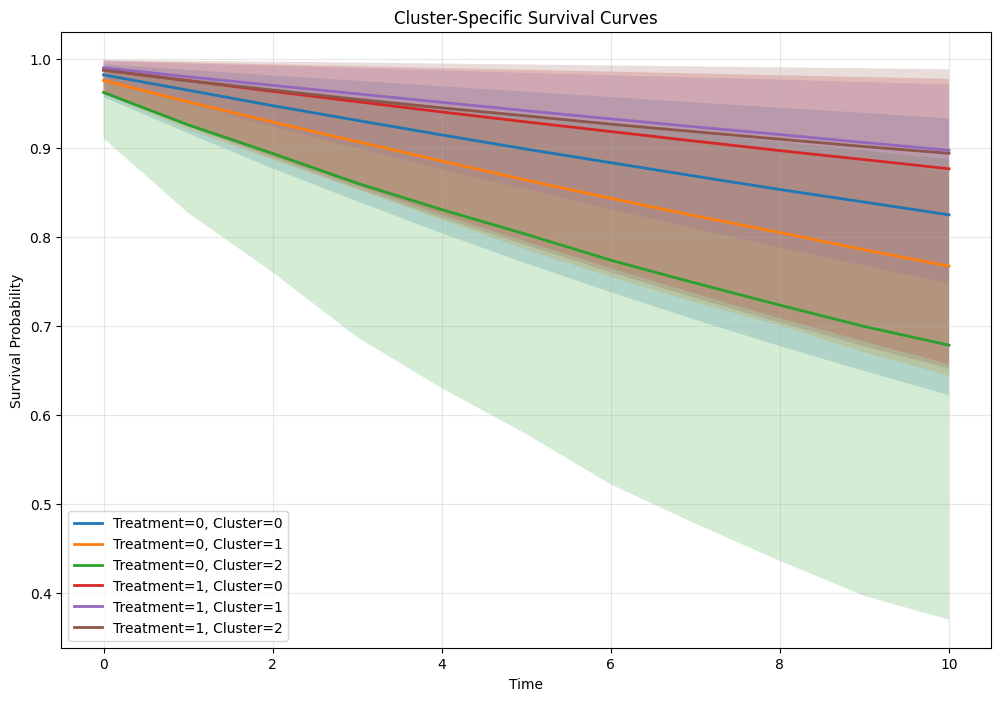

In [55]:
predict_times = list(range(11))
preds_cluster = predict_with_clustering(trial_itt, predict_times=predict_times)
plot_cluster_survival_differences(preds_cluster, predict_times, conf_int=True)

print("Analysis complete. Results saved to:", trial_itt["dir"])

## Cell 13: Analyze Clustering Results

This cell provides additional analysis of the clustering results.
We examine the characteristics of each cluster and their treatment effects.

In [56]:
# Extract baseline characteristics by cluster
baseline_cluster_summary = trial_itt["data"][trial_itt["data"]["period"] == 0].groupby("cluster")[baseline_vars].agg(['mean', 'std'])
print("Baseline Characteristics by Cluster:")
print(baseline_cluster_summary)

# Analyze cluster sizes
cluster_sizes = trial_itt["data"][trial_itt["data"]["period"] == 0].groupby("cluster").size()
print("\nCluster Sizes:")
print(cluster_sizes)

# Extract treatment effects by cluster
print("\nTreatment Effects by Cluster:")
for cluster in sorted(trial_itt["data"]["cluster"].unique()):
    # Filter data for this cluster
    cluster_data = trial_itt["data"][trial_itt["data"]["cluster"] == cluster]
    
    # Calculate treatment effect in this cluster
    treatment_effect = smf.logit(f"{trial_itt['columns']['outcome']} ~ treatment + period", 
                               data=cluster_data).fit(disp=0)
    
    print(f"Cluster {cluster} - Treatment Effect: {treatment_effect.params['treatment']:.4f} (p-value: {treatment_effect.pvalues['treatment']:.4f})")


Baseline Characteristics by Cluster:
               age                  x1                  x2            \
              mean       std      mean       std      mean       std   
cluster                                                                
0        40.025000  3.400509  0.450000  0.503831  0.092022  0.921472   
1        26.181818  4.034651  0.333333  0.478714 -0.186206  0.801041   
2        52.187500  5.612115  0.437500  0.512348  0.001540  1.096981   

               x3                  x4            
             mean       std      mean       std  
cluster                                          
0        0.450000  0.503831 -0.259737  1.093191  
1        0.575758  0.501890  0.499317  0.943781  
2        0.562500  0.512348 -0.179570  0.725003  

Cluster Sizes:
cluster
0    40
1    33
2    16
dtype: int64

Treatment Effects by Cluster:
Cluster 0 - Treatment Effect: -0.8627 (p-value: 0.4622)
Cluster 1 - Treatment Effect: 0.0219 (p-value: 0.9860)
Cluster 2 - Treatment Effec

c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



## Cell 14: Interpretation of Results

We decided to implement clustering after data preparation but before fitting the MSM, specifically in Cell 5. This is because the MSM estimates causal treatment effects based on the data provided. By clustering patients beforehand, we could group them based on baseline covariates (e.g., age, x1, x2, x3, x4) and then allow the MSM to estimate treatment effects within each cluster. Additionally, by placing it after data preparation, we ensured the dataset was clean adn ready, and we could focus on baseline characteristics from period 0, avoiding contamination from post-treatment variables.

We chose 3 clusters in the K-means clustering as a starting point for analysis. We selected K-means clustering for its simplicity, interpretability, and effectiveness with numerical data, which matches the nature of our baseline covariates.

# Key Insights from Clustering-Based Analysis

The PCA visualization of the clustering results reveals three distinct subgroups within the data, with their primary differences captured by PC1, which explains 97.9% of the variance. Cluster 0 is the largest and most homogeneous, cluster 1 shows moderate variability but remains distinct, and cluster 2 is the smallest and most different from the others. The dominance of PC1 underscores the effectiveness of the clustering approach in identifying meaningful patterns, while the minor role of PC2 suggests that within-cluster variations are less significant. These insights support the idea that the clusters represent different profiles—potentially patient subgroups in a medical context—that could exhibit varying responses to treatments or interventions, making this analysis a valuable tool for tailored decision-making.


The scatter plot of the clustering results, visualized using Principal Component Analysis (PCA) on the original scale, shows three distinct clusters—labeled 0 (purple), 1 (red), and 2 (green)—with clear separation along the x-axis (PC1), which accounts for 97.9% of the variance. 

<br>Cluster 0, the largest and most tightly packed, sits around PC1 ≈ -5 to 15, suggesting a uniform subgroup, while Cluster 1 (PC1 ≈ -20 to -5) and Cluster 2 (PC1 ≈ 15 to 35) are smaller and more spread out, especially along PC2, which explains just 0.9% of the variance. The strong influence of PC1 indicates that a single linear combination of features drives the clustering, effectively highlighting distinct subgroups, possibly tied to patient profiles like disease severity or genetic markers. 

<br>Cluster 2 might represent a unique subgroup with different treatment responses, and although the clusters are well-separated, the spread in Clusters 1 and 2 along PC2 suggests potential substructures worth exploring further. Overall, the clustering successfully identifies meaningful patterns, with Cluster 0 as a "typical" group and Clusters 1 and 2 capturing more unique profiles, potentially valuable for personalized medicine.